<h2 align=center> Classify Radio Signals from Outer Space with Keras</h2>

#### Libraries

In [1]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)

#### Loading and Preprocessing the data

In [2]:
train_images = pd.read_csv('dataset/train/images.csv', header = None)
train_labels = pd.read_csv('dataset/train/labels.csv', header = None)

In [3]:
val_images = pd.read_csv('dataset/validation/images.csv', header = None)
val_labels = pd.read_csv('dataset/validation/labels.csv', header = None)

In [4]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [5]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [6]:
print("Training Set Shape: ",train_images.shape,train_labels.shape)
print("Validation Set Shape: ",val_images.shape,val_labels.shape)

Training Set Shape:  (3200, 8192) (3200, 4)
Validation Set Shape:  (800, 8192) (800, 4)


In [7]:
x_train=train_images.values.reshape(3200,64,128,1)
x_val=val_images.values.reshape(800,64,128,1)

y_train=train_labels.values
y_val=val_labels.values

#### Plotting of Spectrograms

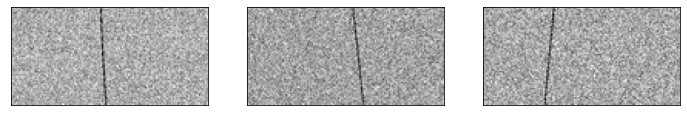

In [8]:
plt.figure(0,figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img=np.squeeze(x_train[np.random.randint(0,x_train.shape[0])]) #squeeze so that we dont get a matrix of 64x128, random to choose a random image from any row(axis=0)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray') #cmap to have grayscale images

#### Data Generators

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
datagen_train= ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val= ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

#### CNN Model

In [11]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
model= Sequential()
# 1st Convolution layer
model.add(Conv2D(32,(5,5),padding='same',input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# 2nd Convolution layer
model.add(Conv2D(64,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
# Fully connected layer
model.add(Dense(1024,kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
# Output Layer          
model.add(Dense(4,activation='softmax'))

#### Learning Rate Scheduling

In [13]:
initial_lr=0.005
scheduler=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=5,
    decay_rate=0.96,                         #0.005*(0.96**5)=0.00407*(0.96**5)=0.0033.......
    staircase=True                           #intial          decayed1          decayed2
)

#### Model Compilation

In [14]:
optimizer=Adam(learning_rate=scheduler)

In [15]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

#### Training the Model

In [17]:
from tensorflow import keras
checkpoint= keras.callbacks.ModelCheckpoint('model_weight.h5',monitor='val_loss', save_weights_only=True, mode='min', verbose=0)
callbacks= [PlotLossesCallback(),checkpoint]

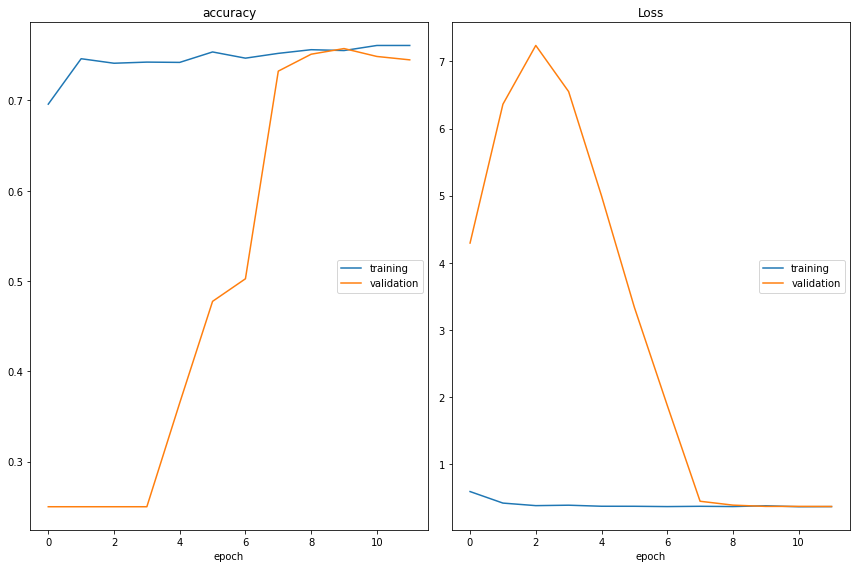

accuracy
	training         	 (min:    0.696, max:    0.761, cur:    0.761)
	validation       	 (min:    0.250, max:    0.757, cur:    0.745)
Loss
	training         	 (min:    0.362, max:    0.588, cur:    0.364)
	validation       	 (min:    0.365, max:    7.239, cur:    0.365)


In [18]:
batch_size=32
history = model.fit( 
                  datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                  steps_per_epoch = len(x_train)//batch_size,
                  validation_data= datagen_val.flow(x_val, y_val, batch_size=batch_size,shuffle=True),
                  validation_steps = len(x_val)//batch_size,
                  epochs=12,
                  callbacks=callbacks
)

#### Model Evaluation

In [20]:
model.evaluate(x_val,y_val)

25/25 [==============================] - 3s 117ms/step - loss: 0.3665 - accuracy: 0.7613


[0.36654362082481384, 0.7612500190734863]

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import numpy as np

In [27]:
y_true = np.argmax(y_val,1)
y_pred = np.argmax(model.predict(x_val),1)
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.52      0.68      0.59       200
           2       0.54      0.38      0.44       200
           3       1.00      1.00      1.00       200

    accuracy                           0.76       800
   macro avg       0.76      0.76      0.76       800
weighted avg       0.76      0.76      0.76       800



In [30]:
print("Classification accuracy: %0.6f"%metrics.accuracy_score(y_true,y_pred))

Classification accuracy: 0.761250


In [28]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]